In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [2]:
!{"ros2 run local_planning_performance_modelling compute_metrics -s"}

cpu_time_and_max_memory: ps_snapshot files not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2021-11-02_10-33-14_965419_run_000000053/benchmark_data/ps_snapshots/ps_*.pkl 
trajectory_length: event navigation_goal_accepted not in events file:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2021-11-02_10-33-14_965419_run_000000053/benchmark_data/run_events.csv 
compute_run_metrics: failed metrics computation for run /home/enrico/ds/performance_modelling/output/test_local_planning/session_2021-11-02_10-33-14_965419_run_000000053 
cpu_time_and_max_memory: ps_snapshot files not found:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2021-10-29_00-45-41_013744_run_000000045/benchmark_data/ps_snapshots/ps_*.pkl 
trajectory_length: event navigation_goal_accepted not in events file:
/home/enrico/ds/performance_modelling/output/test_local_planning/session_2021-10-29_00-45-41_013744_run_000000045/benchmark_data/run

In [3]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green'}
robot_model_color = {'hunter2': 'cyan', 'turtlebot3_waffle_performance_modelling': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['lines.linewidth'] = 3

In [4]:
df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)

# turn odometry_error into alpha_1..4
results_info['run_parameter_names'] += ['alpha_1', 'alpha_2', 'alpha_3', 'alpha_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'alpha_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]
odometry_metrics = [c for c in metrics if 'odometry_error_alpha_' in c]
odometry_mean_metrics = [c for c in metrics if 'odometry_error_alpha_' in c and '_mean' in c]
odometry_std_metrics = [c for c in metrics if 'odometry_error_alpha_' in c and '_std' in c]
odometry_parameters = [f'alpha_{i}' for i in range(1, 5)]
localization_update_metrics = [c for c in metrics if 'localization_update_' in c]
localization_update_mean_metrics = [c for c in metrics if 'localization_update_' in c and '_mean' in c]
localization_update_translation_mean_metrics = [c for c in metrics if 'localization_update_' in c and '_translation_' in c and '_mean' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2

printmd("## Number of Runs")
printmd(f"    {len(df.run_id.unique())}")

printmd("## Run Parameters")
for name in run_parameters:
    values = list(df[name].unique())
    printmd(f"    {name:<70}", sorted(values))

printmd("## Metrics")
for name in metrics_and_versions:
    if name in metrics_versions:
        if len(df[name].unique()) == 1:
            printmd(f"    {name:<70} {sorted(df[name].unique())}")
        else:
            printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
    else:
        printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g}]")

## Number of Runs

    1501

## Run Parameters

    environment_name                                                       ['7A-2', 'airlab', 'fr079', 'intel', 'mexico', 'office_b']

    global_planner_node                                                    ['navfn', 'smac']

    local_planner_node                                                     ['dwb', 'rpp', 'teb']

    localization_node                                                      ['amcl']

    max_steering_angle_deg                                                 [20.0, 30.0, 40.0, 90.0, nan]

    robot_model                                                            ['hunter2', 'turtlebot3_waffle_performance_modelling']

    run_index                                                              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    amcl_alpha_factor                                                      [nan, 0.0, 0.5, 1.0, 2.0]

    alpha_1                                                                [0.0, 0.02, 0.05, 0.1]

    alpha_2                                                                [0.0]

    alpha_3                                                                [0.0, 0.02, 0.05, 0.1]

    alpha_4                                                                [0.0]

## Metrics

    controller_cpu_time                                                    min:       0.52             avg:        106             max:       2098]

    planner_cpu_time                                                       min:       0.27             avg:      33.55             max:       2048]

    system_cpu_time                                                        min:       1.92             avg:      154.9             max:       4357]

    controller_max_memory                                                  min:      22.56             avg:      60.18             max:      79.05]

    planner_max_memory                                                     min:      24.97             avg:      861.1             max:  3.099e+04]

    system_max_memory                                                      min:      138.6             avg:       1069             max:  3.117e+04]

    cpu_time_and_max_memory_version                                        [1]

    trajectory_length_version                                              [1]

    trajectory_length                                                      min:          0             avg:      17.77             max:      118.7]

    execution_time_version                                                 [1]

    execution_time                                                         min:      0.294             avg:      87.38             max:       1691]

    success_rate_version                                                   [1]

    success_rate                                                           min:          0             avg:     0.6422             max:          1]

    odometry_error_alpha_1_mean                                            min:          0             avg:    0.05643             max:      5.761]

    odometry_error_alpha_1_std                                             min:          0             avg:     0.0991             max:      14.65]

    odometry_error_alpha_2_mean                                            min:          0             avg:    0.07572             max:      4.568]

    odometry_error_alpha_2_std                                             min:          0             avg:     0.1619             max:      30.42]

    odometry_error_alpha_3_mean                                            min:  1.775e-17             avg:    0.04841             max:     0.5205]

    odometry_error_alpha_3_std                                             min:          0             avg:    0.01477             max:      0.766]

    odometry_error_alpha_4_mean                                            min:  6.149e-18             avg:     0.1726             max:      1.231]

    odometry_error_alpha_4_std                                             min:          0             avg:     0.1763             max:     0.8164]

    odometry_error_version                                                 [1]

    localization_update_absolute_translation_error_mean                    min:  0.0009785             avg:     0.2965             max:      8.425]

    localization_update_absolute_translation_error_std                     min:          0             avg:     0.1807             max:      6.235]

    localization_update_absolute_rotation_error_mean                       min:   0.001446             avg:    0.03476             max:     0.8999]

    localization_update_absolute_rotation_error_std                        min:          0             avg:    0.04311             max:     0.9418]

    localization_update_relative_translation_error_mean                    min:  0.0008317             avg:    0.01426             max:     0.4853]

    localization_update_relative_translation_error_std                     min:          0             avg:    0.01684             max:        2.3]

    localization_update_relative_rotation_error_mean                       min:  0.0003343             avg:    0.01152             max:     0.3542]

    localization_update_relative_rotation_error_std                        min:          0             avg:    0.03079             max:     0.6203]

    localization_update_normalized_relative_translation_error_mean         min:   0.002408             avg:    0.07827             max:       2.04]

    localization_update_normalized_relative_translation_error_std          min:          0             avg:     0.1265             max:      17.63]

    localization_update_normalized_relative_rotation_error_mean            min:   0.004842             avg:     0.1682             max:      5.809]

    localization_update_normalized_relative_rotation_error_std             min:          0             avg:     0.6717             max:      32.47]

    localization_update_error_version                                      [1]

    localization_update_rate_mean                                          min:     0.2931             avg:      1.106             max:       18.3]

    localization_update_rate_std                                           min:          0             avg:     0.6269             max:       22.1]

    localization_update_rate_version                                       [1]

In [5]:
print(len(df.run_id.unique()))

1501


In [6]:
df.groupby(['robot_model', 'alpha_1'])[odometry_mean_metrics].mean()

odometry_error_alpha_1_mean  odometry_error_alpha_2_mean  odometry_error_alpha_3_mean  odometry_error_alpha_4_mean
robot_model                             alpha_1                                                                                                                    
hunter2                                 0.000                          0.000                        0.000                        0.000                        0.000
                                        0.020                          0.017                        0.010                        0.020                        0.077
                                        0.050                          0.043                        0.024                        0.050                        0.195
                                        0.100                          0.087                        0.048                        0.099                        0.365
turtlebot3_waffle_performance_modelling 0.000                          0.000                        0.000                        0.000                        0.000
                                        0.020                          0.025                        0.027                        0.023                        0.094
                                        0.050                          0.059                        0.093                        0.059                        0.222
                                        0.100                          0.189                        0.324                        0.125                        0.395

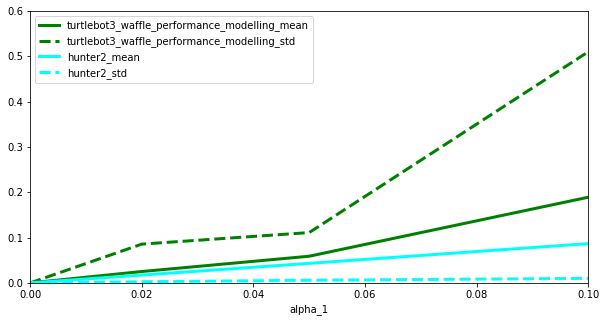

In [7]:
for robot_model in df.robot_model.unique():
    df[df.robot_model == robot_model].groupby('alpha_1').odometry_error_alpha_1_mean.mean().plot(x='alpha_1', figsize=[10, 5], label=robot_model+'_mean', color=robot_model_color[robot_model])
    df[df.robot_model == robot_model].groupby('alpha_1').odometry_error_alpha_1_mean.std().plot(x='alpha_1', figsize=[10, 5], label=robot_model+'_std', color=robot_model_color[robot_model], linestyle='dashed')
plt.legend()
plt.ylim([0, 0.6])
plt.show()

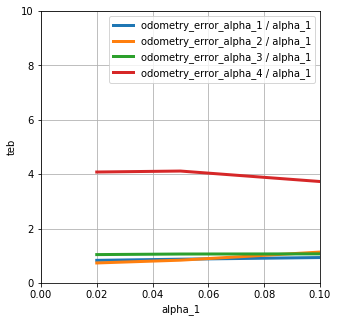

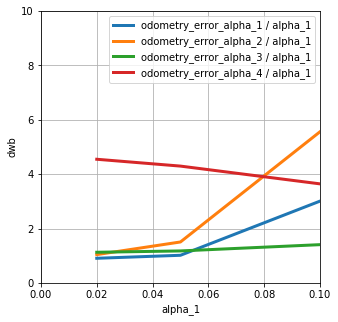

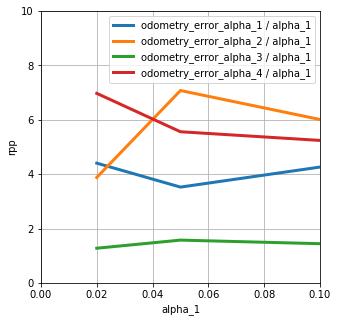

In [9]:
for local_planner_node in df.local_planner_node.unique():
    g1 = df[(df.alpha_1!= 0) & (df.local_planner_node == local_planner_node)].groupby('alpha_1')['odometry_error_alpha_1_mean', 'alpha_1'].mean()
    (g1.odometry_error_alpha_1_mean / g1.alpha_1).plot(x='alpha_1', figsize=[5, 5], grid=True, label='odometry_error_alpha_1 / alpha_1')
    g1 = df[(df.alpha_1!= 0) & (df.local_planner_node == local_planner_node)].groupby('alpha_1')['odometry_error_alpha_2_mean', 'alpha_1'].mean()
    (g1.odometry_error_alpha_2_mean / g1.alpha_1).plot(x='alpha_1', figsize=[5, 5], grid=True, label='odometry_error_alpha_2 / alpha_1')
    g1 = df[(df.alpha_1!= 0) & (df.local_planner_node == local_planner_node)].groupby('alpha_1')['odometry_error_alpha_3_mean', 'alpha_1'].mean()
    (g1.odometry_error_alpha_3_mean / g1.alpha_1).plot(x='alpha_1', figsize=[5, 5], grid=True, label='odometry_error_alpha_3 / alpha_1')
    g1 = df[(df.alpha_1!= 0) & (df.local_planner_node == local_planner_node)].groupby('alpha_1')['odometry_error_alpha_4_mean', 'alpha_1'].mean()
    (g1.odometry_error_alpha_4_mean / g1.alpha_1).plot(x='alpha_1', figsize=[5, 5], grid=True, label='odometry_error_alpha_4 / alpha_1')
    plt.legend()
    plt.ylabel(local_planner_node)
    plt.xlim([0, 0.1])
    plt.ylim([0,10])
    plt.show()

In [10]:
df.groupby(['robot_model', 'global_planner_node', 'local_planner_node'])[localization_update_translation_mean_metrics].mean().sort_values('localization_update_absolute_translation_error_mean')

localization_update_absolute_translation_error_mean  localization_update_relative_translation_error_mean  localization_update_normalized_relative_translation_error_mean
robot_model                             global_planner_node local_planner_node                                                                                                                                                                          
hunter2                                 smac                teb                                                             0.137                                                0.013                                                0.043             
turtlebot3_waffle_performance_modelling smac                teb                                                             0.224                                                0.012                                                0.067             
hunter2                                 navfn               teb                                                             0.285                                                0.016                                                0.050             
turtlebot3_waffle_performance_modelling navfn               teb                                                             0.348                                                0.015                                                0.082             
                                                            rpp                                                             0.380                                                0.015                                                0.198             
                                                            dwb                                                             0.384                                                0.013                                                0.109

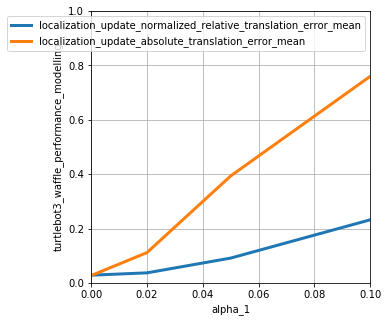

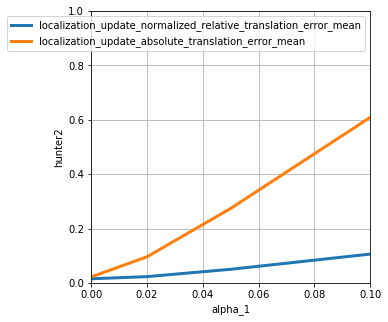

In [11]:
for robot_model in df.robot_model.unique():
    df[df.robot_model == robot_model].groupby('alpha_1').localization_update_normalized_relative_translation_error_mean.mean().plot(x='alpha_1', grid=True)
    df[df.robot_model == robot_model].groupby('alpha_1').localization_update_absolute_translation_error_mean.mean().plot(x='alpha_1', grid=True)
    plt.legend()
    plt.ylabel(robot_model)
    plt.xlim([0, 0.1])
    plt.ylim([0, 1.0])
    plt.show()

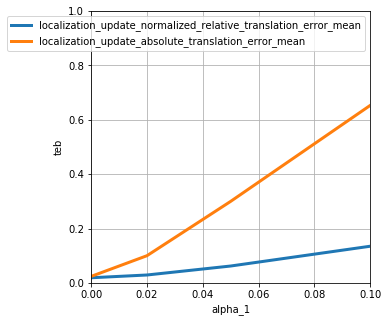

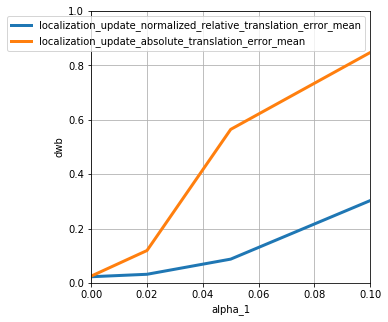

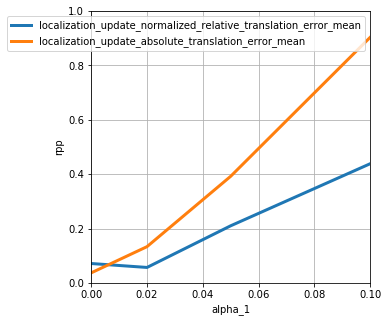

In [12]:
for local_planner_node in df.local_planner_node.unique():
    df[df.local_planner_node == local_planner_node].groupby('alpha_1').localization_update_normalized_relative_translation_error_mean.mean().plot(x='alpha_1', grid=True)
    df[df.local_planner_node == local_planner_node].groupby('alpha_1').localization_update_absolute_translation_error_mean.mean().plot(x='alpha_1', grid=True)
    plt.legend()
    plt.ylabel(local_planner_node)
    plt.xlim([0, 0.1])
    plt.ylim([0, 1.0])
    plt.show()

controller_cpu_time       planner_cpu_time       system_cpu_time      
                                                                                              mean count             mean count            mean count
robot_model                             local_planner_node global_planner_node                                                                       
turtlebot3_waffle_performance_modelling rpp                navfn                            24.541    94           22.983    94          60.212    94
                                        dwb                navfn                            46.365   206           34.062   206         102.217   206
                                        teb                smac                            100.775   296           26.483   296         139.095   296
hunter2                                 teb                navfn                           122.074   422           23.746   422         159.341   422
turtlebot3_waffle_performance_modelling teb                navfn                           139.137   291           31.432   291         187.409   291
hunter2                                 teb                smac                            132.025   192           73.847   192         222.867   192

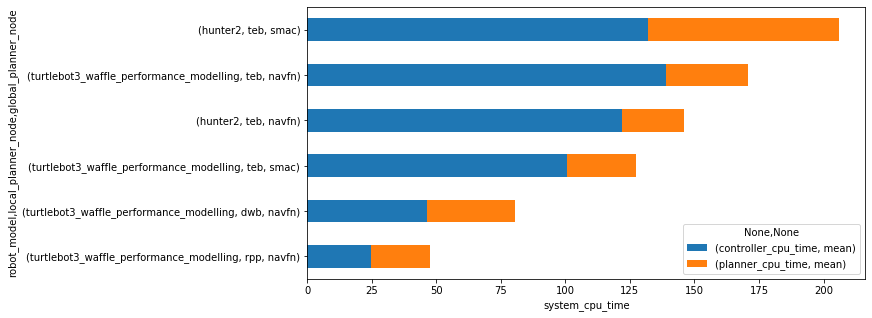

In [13]:
cpu_time_metrics_df = df.groupby([df.robot_model, df.local_planner_node, df.global_planner_node])[cpu_time_metrics].agg(['mean', 'count']).sort_values(by=('system_cpu_time', 'mean'))
ax = cpu_time_metrics_df.plot.barh(y=[('controller_cpu_time', 'mean'), ('planner_cpu_time', 'mean')], stacked=True, figsize=[10, 5],)
ax.set_xlabel("system_cpu_time")
cpu_time_metrics_df

controller_max_memory       planner_max_memory       system_max_memory      
                                                                                                mean count               mean count              mean count
robot_model                             local_planner_node global_planner_node                                                                             
turtlebot3_waffle_performance_modelling dwb                navfn                              32.426   206             57.697   206           215.758   206
                                        rpp                navfn                              26.280    94             62.998    94           256.782    94
hunter2                                 teb                navfn                              66.724   422             59.942   422           258.240   422
turtlebot3_waffle_performance_modelling teb                navfn                              68.575   291             60.387   291           298.017   291
hunter2                                 teb                smac                               68.119   192          2,309.301   192         2,521.249   192
turtlebot3_waffle_performance_modelling teb                smac                               67.508   296          2,663.456   296         2,894.057   296

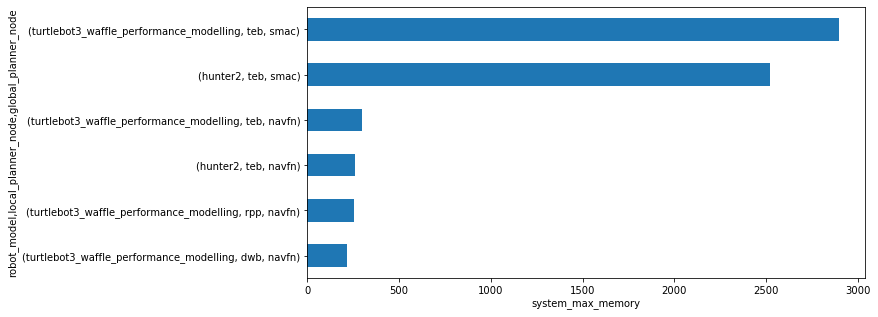

In [14]:
cpu_time_metrics_df = df.groupby([df.robot_model, df.local_planner_node, df.global_planner_node])[max_memory_metrics].agg(['mean', 'count']).sort_values(by=('system_max_memory', 'mean'))
ax = cpu_time_metrics_df.plot.barh(y=('system_max_memory', 'mean'), figsize=[10, 5], legend=False)
ax.set_xlabel("system_max_memory")
cpu_time_metrics_df